In [3]:
# Read data
# ==============================================================================
from datetime import datetime, timedelta
import glob
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [4]:
# Load data
# =============================================================================
parameter_name_wind = "fu3010z0"
station_name = "COM"

data_all = pd.concat(
    [
        pd.read_csv(file, sep=";", encoding="latin-1")
        for file in glob.glob("./data/*-VQHA80.csv")
    ]
)

data_all["Date"] = pd.to_datetime(data_all["Date"], format="%Y%m%d%H%M")
data_all = data_all.set_index("Date")

data_station = data_all[data_all["Station/Location"] == station_name]

data_station = data_station.sort_index()
data_station = data_station[~data_station.index.duplicated()]
data_station = data_station.drop(data_station[data_station[parameter_name_wind] == "-"].index)
data_station[parameter_name_wind] = data_station[parameter_name_wind].astype(float)
data_station = data_station.asfreq("600S", method="bfill")
data_station = data_station[parameter_name_wind]

start_train_date = "2023-09-12 00:00:00"
end_train_date = "2023-09-19 07:00:00"

data_train = data_station.loc[start_train_date:end_train_date]
data_test = data_station.loc[end_train_date:]

print(
    f"Complete time series : {data_station.index.min()} --- {data_station.index.max()}  (n={len(data_station)})"
)
print(
    f"Training dates       : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates           : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})"
)

Complete time series : 2023-09-11 07:10:00 --- 2023-09-19 15:50:00  (n=1205)
Training dates       : 2023-09-12 00:00:00 --- 2023-09-19 07:00:00  (n=1051)
Test dates           : 2023-09-19 07:00:00 --- 2023-09-19 15:50:00  (n=54)


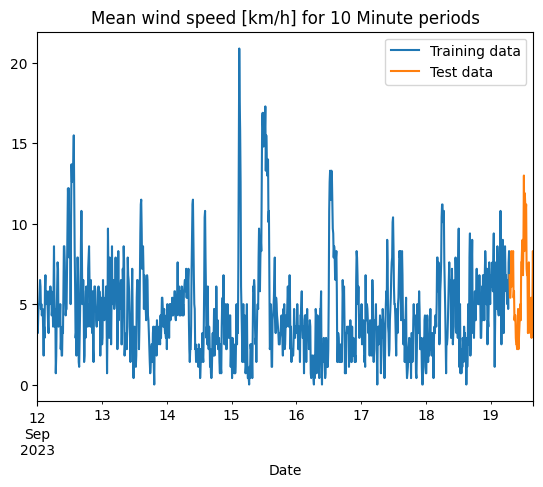

In [5]:
# Plot test and training data
# ======================================================================================
fig, ax=plt.subplots()
data_train.plot(ax=ax, label='Training data')
data_test.plot(ax=ax, label='Test data')
ax.set_title('Mean wind speed [km/h] for 10 Minute periods')
ax.legend();

In [6]:
# Hyperparameter grid search
# ==============================================================================

steps = 36
forecaster = ForecasterAutoreg(
    regressor=LinearRegression(), lags=10
)

lags_grid = [1, 2, 3, 5, 10, 20, 30, 40, 60, 70, 80]

param_grid = {}

results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=data_train,
    param_grid=param_grid,
    lags_grid=lags_grid,
    steps=steps,
    refit=False,
    metric="mean_absolute_error",
    initial_train_size=int(len(data_train) * 0.5),
    fixed_train_size=False,
    return_best=True,
    n_jobs="auto",
    verbose=False,
)
results_grid

Number of models compared: 11.


lags grid:   0%|          | 0/11 [00:00<?, ?it/s]

params grid:   0%|          | 0/1 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {}
  Backtesting metric: 2.081385840741197



,lags,params,mean_absolute_error
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",{},2.081386
0,[1],{},2.082733
3,"[1, 2, 3, 4, 5]",{},2.084457
2,"[1, 2, 3]",{},2.088030
1,"[1, 2]",{},2.097966
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},2.118949
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},2.120191
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},2.124432
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},2.151514
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{},2.162316


In [7]:
# Mean absolute error for random walk simulation
# ==============================================================================
mean_absolute_error(data_train.iloc[1:], data_train.shift(1).iloc[1:])

1.4407619047619047

In [8]:
# Model training with "best" number of lags
# =============================================================================
forecaster = ForecasterAutoreg(
    regressor=LinearRegression(), lags=10
)

forecaster.fit(y=data_train)

In [9]:
# Model prediction
# =============================================================================
predictions = forecaster.predict(steps=36)

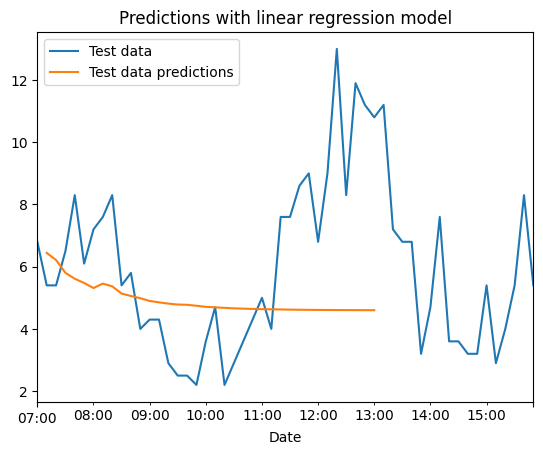

In [10]:
# Plot predictions
# =============================================================================
fig, ax = plt.subplots()
data_test.plot(ax=ax, label="Test data")
predictions.plot(ax=ax, label="Test data predictions")
ax.set_title("Predictions with linear regression model")
ax.legend();

In [11]:
# Iterative model training and prediction with "best" number of lags
# =============================================================================
predictions_list = []
date = datetime.strptime(end_train_date, '%Y-%m-%d %H:%M:%S')
for i in range(53):
    forecaster = ForecasterAutoreg(
        regressor=LinearRegression(), lags=10
    )
    forecaster.fit(y=data_station.loc[:date + timedelta(minutes=i*10)])
    predictions_list.append(forecaster.predict(steps=1))

predictions_iterative = pd.concat(predictions_list)

In [12]:
# Mean absolute error for random walk simulation
# ==============================================================================
mean_absolute_error(data_test.iloc[1:], predictions_iterative.iloc[:])

1.4341357338170533

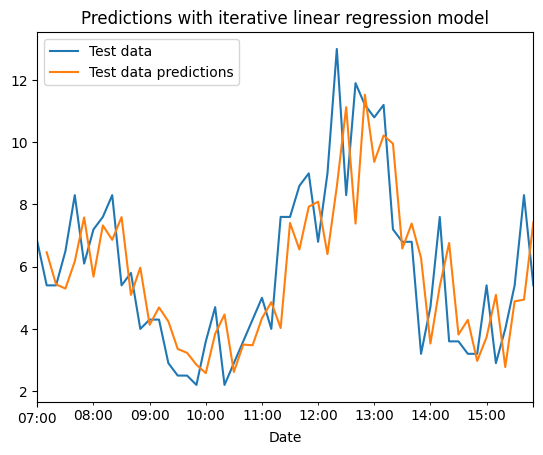

In [13]:
# Plot predictions
# =============================================================================
fig, ax = plt.subplots()
data_test.plot(ax=ax, label="Test data")
predictions_iterative.plot(ax=ax, label="Test data predictions")
ax.set_title("Predictions with iterative linear regression model")
ax.legend();